In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

pd.set_option('display.max_colwidth', 200)


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("datasets/"))

# Any results you write to the current directory are saved as output.

['.DS_Store', 'archive.zip', 'SPAM.csv']


In [2]:
#Firstly we read our data
data = pd.read_csv("datasets/SPAM.csv")

In [70]:
data.head()

,Category,Message
0,0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives around here though"


In [4]:
data['Category'].value_counts(normalize=True)

Category
ham     0.865937
spam    0.134063
Name: proportion, dtype: float64

In [5]:
data['Category'] = data['Category'].map({'ham': 0, 'spam': 1})

<h3>Preprocessing 

In [6]:
import re

In [7]:
import pandas as pd
from sklearn.pipeline import Pipeline
import nltk
from nltk.stem import WordNetLemmatizer

# Download NLTK data if you haven't already
nltk.download('punkt')
nltk.download('wordnet')

# Sample DataFrame
nlp_data = data.copy()

# Custom transformers for lowercase, tokenization, and lemmatization
class RegexTransformer:
    def transform(self, X):
        return X.apply(lambda x: re.sub("[^a-zA-Z]"," ",x))

class LowercaseTransformer:
    def transform(self, X):
        return X.apply(lambda x: x.lower())

class TokenizeTransformer:
    def transform(self, X):
        return X.apply(lambda x: nltk.word_tokenize(x))

class LemmatizeTransformer:
    def transform(self, X):
        lemmatizer = WordNetLemmatizer()
        return X.apply(lambda x: [lemmatizer.lemmatize(word, "v") for word in x])

# Create a data preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('lowercase', RegexTransformer()),
    ('lowercase', LowercaseTransformer()),
    ('tokenize', TokenizeTransformer()),
    ('lemmatize', LemmatizeTransformer())
])

# Apply the pipeline to the 'Message' column
nlp_data['Message'] = preprocessing_pipeline.transform(nlp_data['Message'])


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/askarbabuu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/askarbabuu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<h3>NLP

In [22]:
description_list = nlp_data['Message'].apply(lambda x: " ".join(x)).explode().tolist()

In [30]:
nlp_data.shape

(5572, 2)

In [36]:
from sklearn.feature_extraction.text import CountVectorizer 
max_features = 3000 #We use the most common word
count_vectorizer = CountVectorizer(max_features = max_features, stop_words = "english")
sparce_matrix = count_vectorizer.fit_transform(description_list).toarray()

In [40]:
print("the most using {} words: {}".format(max_features, count_vectorizer.get_feature_names_out()))

the most using 3000 words: ['aah' 'aathi' 'abi' ... 'yuo' 'yup' 'zed']


In [58]:
from sklearn.model_selection import train_test_split

y = nlp_data.iloc[:,0].values
x = sparce_matrix
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.1, random_state = 42)

**Gaussian Naive Bayes**

In [62]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(x_train, y_train)
print("the accuracy of our model: {}".format(nb.score(x_test,y_test)))

the accuracy of our model: 0.8637992831541219


**Logistic Regression**

In [65]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(x_train, y_train)
print("the accuracy of our model: {}".format(lr.score(x_test,y_test)))

the accuracy of our model: 0.982078853046595


**LSTM Network**

In [104]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam
import matplotlib.pyplot as plt


# Split the data into training, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

# Initialize the RNN model
regressor = Sequential()

# Add LSTM layers with dropout
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

# Add the output layer
regressor.add(Dense(units=1))

# Define a range of learning rates to experiment with
learning_rates = [0.001, 0.01, 0.1]

# Initialize lists to store training histories for different learning rates
histories = []

for lr in learning_rates:
    # Compile the model with the current learning rate
    optimizer = Adam(learning_rate=lr)
    regressor.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model with validation data
    history = regressor.fit(x_train, y_train, epochs=3, batch_size=120, validation_data=(x_val, y_val))
    
    # Store the training history for this learning rate
    histories.append(history)

Epoch 1/3
38/38 [==============================] - 359s 9s/step - loss: 0.4576 - accuracy: 0.8658 - val_loss: 0.3793 - val_accuracy: 0.8707
Epoch 2/3
38/38 [==============================] - 474s 13s/step - loss: 0.3859 - accuracy: 0.8654 - val_loss: 0.3809 - val_accuracy: 0.8707
Epoch 3/3
38/38 [==============================] - 350s 9s/step - loss: 0.3999 - accuracy: 0.8620 - val_loss: 0.3643 - val_accuracy: 0.8654


Epoch 1/3
38/38 [==============================] - 407s 10s/step - loss: 0.4882 - accuracy: 0.8468 - val_loss: 0.3896 - val_accuracy: 0.8707
Epoch 2/3
38/38 [==============================] - 285s 7s/step - loss: 0.3969 - accuracy: 0.8658 - val_loss: 0.3849 - val_accuracy: 0.8707
Epoch 3/3
38/38 [==============================] - 384s 10s/step - loss: 0.3965 - accuracy: 0.8658 - val_loss: 0.3863 - val_accuracy: 0.8707


Epoch 1/3
38/38 [==============================] - 270s 7s/step - loss: 2.0372 - accuracy: 0.8658 - val_loss: 1.9939 - val_accuracy: 0.8707
Epoch 2/3
38/38 [==============================] - 209s 5s/step - loss: 2.0696 - accuracy: 0.8658 - val_loss: 1.9939 - val_accuracy: 0.8707
Epoch 3/3
38/38 [==============================] - 205s 5s/step - loss: 2.0696 - accuracy: 0.8658 - val_loss: 1.9939 - val_accuracy: 0.8707


In [107]:
histories[0].history

{'loss': [0.4575915038585663, 0.38594749569892883, 0.39991509914398193],
 'accuracy': [0.8658290505409241, 0.8653802871704102, 0.8620148301124573],
 'val_loss': [0.379335880279541, 0.38091108202934265, 0.36431366205215454],
 'val_accuracy': [0.8707360625267029, 0.8707360625267029, 0.865350067615509]}

In [111]:
# Evaluate and compare models with different learning rates on the validation set
train_losses = []
validation_losses = []

for history in histories:
    tarin_loss, val_loss = history.history['loss'][2], history.history['val_loss'][2]
    validation_losses.append(val_loss)
    train_losses.append(tarin_loss)

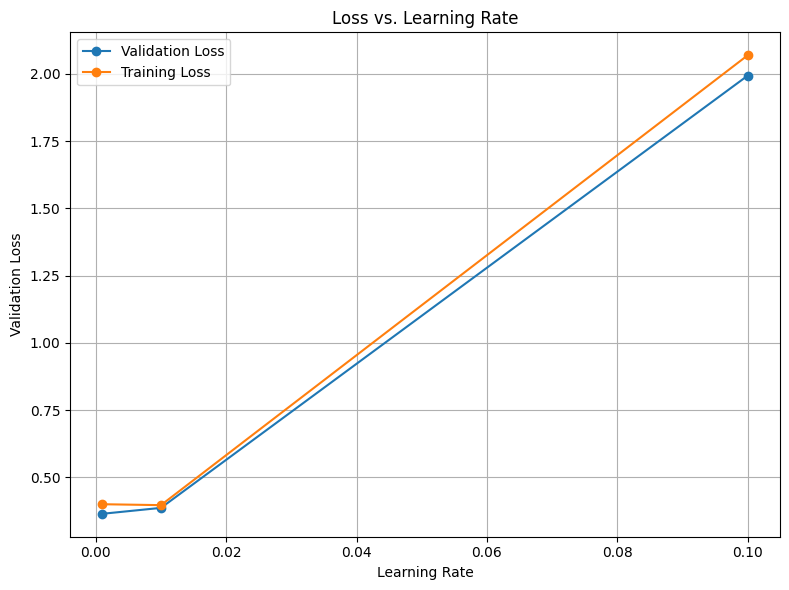

In [118]:
# Visualize the performance for different learning rates on the validation set
plt.figure(figsize=(8, 6))
plt.plot(learning_rates, validation_losses, marker='o', label='Validation Loss')
plt.plot(learning_rates, train_losses, marker='o', label='Training Loss')
plt.title('Loss vs. Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Loss')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()



In [119]:
# You can choose the learning rate that results in the best validation performance
best_lr = learning_rates[validation_losses.index(min(validation_losses))]
print("Best Learning Rate:", best_lr)

Best Learning Rate: 0.001


In [123]:
# Retrain the model with the best learning rate on the entire training dataset
best_optimizer = Adam(learning_rate=best_lr)
regressor.compile(optimizer=best_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
regressor.fit(x_train, y_train, epochs=3, batch_size=32)

# Evaluate the final model on the test data
test_loss, test_accuracy = regressor.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/3
140/140 [==============================] - 326s 2s/step - loss: 2.0696 - accuracy: 0.8658
Epoch 2/3
140/140 [==============================] - 320s 2s/step - loss: 2.0696 - accuracy: 0.8658
Epoch 3/3
18/18 [==============================] - 8s 404ms/step - loss: 2.1285 - accuracy: 0.8620
Test Loss: 2.1285321712493896
Test Accuracy: 0.8620071411132812
